# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [2]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [3]:
bbc.sample(5)

,category,text
1096,tech,internet boom for gift shopping cyberspace is ...
1748,business,id theft surge hits us consumers almost a quar...
1878,sport,wales hails new superstar one game into his si...
982,sport,dementieva prevails in hong kong elena dementi...
1053,entertainment,black sabbath top rock album poll black sabbat...


In [4]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
bbc['category_id'] = bbc['category'].factorize()[0]
bbc.head()

,category,text,category_id
0,tech,tv future in the hands of viewers with home th...,0
1,business,worldcom boss left books alone former worldc...,1
2,sport,tigers wary of farrell gamble leicester say ...,2
3,sport,yeading face newcastle in fa cup premiership s...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,3


In [6]:
bbc_id = bbc[['category','category_id']].drop_duplicates().sort_values('category_id')
bbc_id

,category,category_id
0,tech,0
1,business,1
2,sport,2
4,entertainment,3
5,politics,4


In [7]:
category_to_id = dict(bbc_id.values)
id_to_category = dict(bbc_id[['category_id','category']].values)

In [8]:
category_to_id

{'business': 1, 'entertainment': 3, 'politics': 4, 'sport': 2, 'tech': 0}

In [9]:
id_to_category

{0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [10]:
bbc.groupby('category').category_id.count()

category
business         510
entertainment    386
politics         417
sport            511
tech             401
Name: category_id, dtype: int64

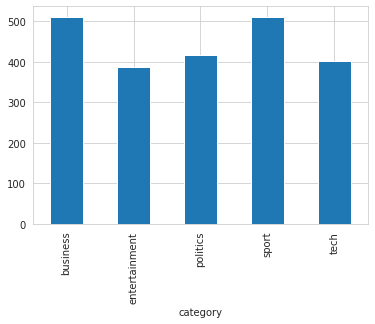

In [11]:
bbc.groupby('category').category_id.count().plot.bar(ylim=0)

In [13]:
from collections import Counter

vocab = Counter()
for lines in bbc['text']:
  for word in lines.split(' '):
    vocab[word] +=1
vocab.most_common(20)


[('', 65553),
 ('the', 52567),
 ('to', 24955),
 ('of', 19947),
 ('and', 18561),
 ('a', 18251),
 ('in', 17570),
 ('s', 9007),
 ('for', 8884),
 ('is', 8515),
 ('that', 8135),
 ('it', 7584),
 ('on', 7460),
 ('was', 6016),
 ('he', 5933),
 ('be', 5765),
 ('with', 5313),
 ('said', 5072),
 ('as', 4976),
 ('has', 4952)]

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
features.shape

(2225, 14415)

In [20]:
category_to_id.items()

dict_items([('tech', 0), ('business', 1), ('sport', 2), ('entertainment', 3), ('politics', 4)])

In [21]:
sorted(category_to_id.items())

[('business', 1),
 ('entertainment', 3),
 ('politics', 4),
 ('sport', 2),
 ('tech', 0)]

In [15]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
vocab_reduced = Counter()

for w,c in vocab.items():
  if not w in stop_words:
    vocab_reduced[w] = c
vocab_reduced.most_common(20)

[('', 65553),
 ('said', 5072),
 ('-', 3195),
 ('mr', 2992),
 ('would', 2574),
 ('also', 2154),
 ('people', 1970),
 ('new', 1957),
 ('us', 1786),
 ('one', 1705),
 ('could', 1509),
 ('said.', 1499),
 ('year', 1396),
 ('last', 1380),
 ('first', 1277),
 ('.', 1171),
 ('two', 1161),
 ('government', 1085),
 ('world', 1076),
 ('uk', 993)]

In [17]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()
def tokenizer(text):
  return text.split()

def tokenizer_porter(text):
  return [porter.stem(word) for word in text.split()]

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_words, tokenizer=tokenizer_porter)
features = tfidf.fit_transform(bbc['text']).toarray()
labels = bbc['category_id']

In [22]:
from sklearn.model_selection import train_test_split
X = features
y = bbc['category_id']
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=60)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

dict_model = {'logistic': LogisticRegression(),
              'knn': KNeighborsClassifier(), # SGDClassifier
              'decisiontree': DecisionTreeClassifier(),
              'randomforest': RandomForestClassifier(),
              'gbdt': GradientBoostingClassifier()}

for key in dict_model:
    model = dict_model[key].fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    print(f'Train acc of {key}: ', accuracy_score(y_train, y_train_pred))
    print(f'Test acc of {key}: ', accuracy_score(y_test, y_test_pred))

Train acc of logistic:  0.998314606741573
Test acc of logistic:  0.9707865168539326
Train acc of knn:  0.9786516853932584
Test acc of knn:  0.9617977528089887
Train acc of decisiontree:  1.0
Test acc of decisiontree:  0.8449438202247191
Train acc of randomforest:  1.0
Test acc of randomforest:  0.950561797752809
Train acc of gbdt:  1.0
Test acc of gbdt:  0.9550561797752809


In [28]:
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier

vote = VotingClassifier(
    estimators=[('lr', LogisticRegression()), 
                ('rf', RandomForestClassifier()), 
                ('lgb', LGBMClassifier())], 
    voting='soft',
    weights=[1, 2, 3]
)
vote.fit(x_train, y_train)
print('Accuracy score of Voting Clf: ', accuracy_score(y_test, vote.predict(x_test)))

Accuracy score of Voting Clf:  0.9595505617977528
